# Deep Q-learning

In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [53]:
import gym
import tensorflow as tf
import numpy as np

>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

In [26]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 9688706106667889574, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 275775488
 locality {
   bus_id: 1
 }
 incarnation: 12062135433877321349
 physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:24:00.0, compute capability: 6.1"]

In [27]:
# Create the Cart-Pole game environment
env = gym.make('CartPole-v0')

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [28]:
env.reset()
rewards = []
for _ in range(100):
    #env.render()
    state, reward, done, info = env.step(env.action_space.sample()) # take a random action
    rewards.append(reward)
    if done:
        rewards = []
        env.reset()

To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [29]:
print(rewards[-20:])

[]


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [30]:
class QNetwork:
    def __init__(self, learning_rate=0.01, state_size=4, 
                 action_size=2, hidden_size=10, 
                 name='QNetwork'):
        # state inputs to the Q-network
        with tf.variable_scope(name):
            self.inputs_ = tf.placeholder(tf.float32, [None, state_size], name='inputs')
            
            # One hot encode the actions to later choose the Q-value for the action
            self.actions_ = tf.placeholder(tf.int32, [None], name='actions')
            one_hot_actions = tf.one_hot(self.actions_, action_size)
            
            # Target Q values for training
            self.targetQs_ = tf.placeholder(tf.float32, [None], name='target')
            
            # ReLU hidden layers
            self.fc1 = tf.contrib.layers.fully_connected(self.inputs_, hidden_size)
            self.fc2 = tf.contrib.layers.fully_connected(self.fc1, hidden_size)

            # Linear output layer
            self.output = tf.contrib.layers.fully_connected(self.fc2, action_size, 
                                                            activation_fn=None)
            
            ### Train with loss (targetQ - Q)^2
            # output has length 2, for two actions. This next line chooses
            # one value from output (per row) according to the one-hot encoded actions.
            self.Q = tf.reduce_sum(tf.multiply(self.output, one_hot_actions), axis=1)
            
            self.loss = tf.reduce_mean(tf.square(self.targetQs_ - self.Q))
            self.opt = tf.train.AdamOptimizer(learning_rate).minimize(self.loss)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [31]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
            
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [32]:
train_episodes = 1000          # max number of episodes to learn from
max_steps = 200                # max steps in an episode
gamma = 0.99                   # future reward discount

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
hidden_size = 64               # number of units in each Q-network hidden layer
learning_rate = 0.0001         # Q-network learning rate

# Memory parameters
memory_size = 10000            # memory capacity
batch_size = 20                # experience mini-batch size
pretrain_length = batch_size   # number experiences to pretrain the memory

In [33]:
tf.reset_default_graph()
mainQN = QNetwork(name='main', hidden_size=hidden_size, learning_rate=learning_rate)

## Populate the experience memory

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [34]:
# Initialize the simulation
env.reset()
# Take one random step to get the pole and cart moving
state, reward, done, _ = env.step(env.action_space.sample())

memory = Memory(max_size=memory_size)

# Make a bunch of random actions and store the experiences
for ii in range(pretrain_length):
    # Uncomment the line below to watch the simulation
    # env.render()

    # Make a random action
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)

    if done:
        # The simulation fails so no next state
        next_state = np.zeros(state.shape)
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        
        # Start new episode
        env.reset()
        # Take one random step to get the pole and cart moving
        state, reward, done, _ = env.step(env.action_space.sample())
    else:
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        state = next_state

## Training

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [35]:
# Now train with experiences
saver = tf.train.Saver()
rewards_list = []
with tf.Session() as sess:
    # Initialize variables
    sess.run(tf.global_variables_initializer())
    
    step = 0
    for ep in range(1, train_episodes):
        total_reward = 0
        t = 0
        while t < max_steps:
            step += 1
            # Uncomment this next line to watch the training
            # env.render() 
            
            # Explore or Exploit
            explore_p = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*step) 
            if explore_p > np.random.rand():
                # Make a random action
                action = env.action_space.sample()
            else:
                # Get action from Q-network
                feed = {mainQN.inputs_: state.reshape((1, *state.shape))}
                Qs = sess.run(mainQN.output, feed_dict=feed)
                action = np.argmax(Qs)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
    
            total_reward += reward
            
            if done:
                # the episode ends so no next state
                next_state = np.zeros(state.shape)
                t = max_steps
                
                print('Episode: {}'.format(ep),
                      'Total reward: {}'.format(total_reward),
                      'Training loss: {:.4f}'.format(loss),
                      'Explore P: {:.4f}'.format(explore_p))
                rewards_list.append((ep, total_reward))
                
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                
                # Start new episode
                env.reset()
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())

            else:
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                state = next_state
                t += 1
            
            # Sample mini-batch from memory
            batch = memory.sample(batch_size)
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            rewards = np.array([each[2] for each in batch])
            next_states = np.array([each[3] for each in batch])
            
            # Train network
            target_Qs = sess.run(mainQN.output, feed_dict={mainQN.inputs_: next_states})
            
            # Set target_Qs to 0 for states where episode ends
            episode_ends = (next_states == np.zeros(states[0].shape)).all(axis=1)
            target_Qs[episode_ends] = (0, 0)
            
            targets = rewards + gamma * np.max(target_Qs, axis=1)

            loss, _ = sess.run([mainQN.loss, mainQN.opt],
                                feed_dict={mainQN.inputs_: states,
                                           mainQN.targetQs_: targets,
                                           mainQN.actions_: actions})
        
    saver.save(sess, "checkpoints/cartpole.ckpt")


Episode: 1 Total reward: 9.0 Training loss: 1.1643 Explore P: 0.9991
Episode: 2 Total reward: 17.0 Training loss: 1.2050 Explore P: 0.9974
Episode: 3 Total reward: 21.0 Training loss: 1.1437 Explore P: 0.9954
Episode: 4 Total reward: 11.0 Training loss: 1.1112 Explore P: 0.9943
Episode: 5 Total reward: 8.0 Training loss: 1.1113 Explore P: 0.9935
Episode: 6 Total reward: 21.0 Training loss: 1.1652 Explore P: 0.9914
Episode: 7 Total reward: 18.0 Training loss: 1.1052 Explore P: 0.9897
Episode: 8 Total reward: 10.0 Training loss: 1.2017 Explore P: 0.9887
Episode: 9 Total reward: 16.0 Training loss: 1.1865 Explore P: 0.9871
Episode: 10 Total reward: 21.0 Training loss: 1.3002 Explore P: 0.9851
Episode: 11 Total reward: 73.0 Training loss: 1.2112 Explore P: 0.9780
Episode: 12 Total reward: 12.0 Training loss: 1.4030 Explore P: 0.9768
Episode: 13 Total reward: 15.0 Training loss: 1.2086 Explore P: 0.9754
Episode: 14 Total reward: 11.0 Training loss: 1.3084 Explore P: 0.9743
Episode: 15 Total

Episode: 120 Total reward: 30.0 Training loss: 32.3086 Explore P: 0.8054
Episode: 121 Total reward: 20.0 Training loss: 50.4827 Explore P: 0.8039
Episode: 122 Total reward: 16.0 Training loss: 73.5090 Explore P: 0.8026
Episode: 123 Total reward: 12.0 Training loss: 46.3060 Explore P: 0.8016
Episode: 124 Total reward: 13.0 Training loss: 3.0683 Explore P: 0.8006
Episode: 125 Total reward: 13.0 Training loss: 30.1543 Explore P: 0.7996
Episode: 126 Total reward: 15.0 Training loss: 97.3849 Explore P: 0.7984
Episode: 127 Total reward: 18.0 Training loss: 3.5709 Explore P: 0.7970
Episode: 128 Total reward: 9.0 Training loss: 56.1732 Explore P: 0.7963
Episode: 129 Total reward: 39.0 Training loss: 71.9678 Explore P: 0.7932
Episode: 130 Total reward: 21.0 Training loss: 2.1256 Explore P: 0.7916
Episode: 131 Total reward: 14.0 Training loss: 67.3467 Explore P: 0.7905
Episode: 132 Total reward: 11.0 Training loss: 2.7239 Explore P: 0.7896
Episode: 133 Total reward: 11.0 Training loss: 57.7519 E

Episode: 234 Total reward: 30.0 Training loss: 40.6033 Explore P: 0.6684
Episode: 235 Total reward: 12.0 Training loss: 0.6667 Explore P: 0.6676
Episode: 236 Total reward: 20.0 Training loss: 23.9978 Explore P: 0.6663
Episode: 237 Total reward: 20.0 Training loss: 0.8199 Explore P: 0.6650
Episode: 238 Total reward: 20.0 Training loss: 40.1186 Explore P: 0.6637
Episode: 239 Total reward: 16.0 Training loss: 16.4371 Explore P: 0.6626
Episode: 240 Total reward: 20.0 Training loss: 41.5673 Explore P: 0.6613
Episode: 241 Total reward: 22.0 Training loss: 15.0334 Explore P: 0.6599
Episode: 242 Total reward: 10.0 Training loss: 19.8989 Explore P: 0.6592
Episode: 243 Total reward: 23.0 Training loss: 1.1403 Explore P: 0.6578
Episode: 244 Total reward: 9.0 Training loss: 11.8459 Explore P: 0.6572
Episode: 245 Total reward: 11.0 Training loss: 1.2410 Explore P: 0.6565
Episode: 246 Total reward: 14.0 Training loss: 28.7315 Explore P: 0.6556
Episode: 247 Total reward: 16.0 Training loss: 25.8808 E

Episode: 347 Total reward: 86.0 Training loss: 1.3544 Explore P: 0.4530
Episode: 348 Total reward: 92.0 Training loss: 1.7970 Explore P: 0.4490
Episode: 349 Total reward: 49.0 Training loss: 1.5299 Explore P: 0.4468
Episode: 350 Total reward: 56.0 Training loss: 31.2454 Explore P: 0.4444
Episode: 351 Total reward: 73.0 Training loss: 93.3041 Explore P: 0.4412
Episode: 352 Total reward: 38.0 Training loss: 1.9080 Explore P: 0.4396
Episode: 353 Total reward: 18.0 Training loss: 1.5246 Explore P: 0.4388
Episode: 354 Total reward: 56.0 Training loss: 36.3203 Explore P: 0.4364
Episode: 355 Total reward: 48.0 Training loss: 27.9628 Explore P: 0.4344
Episode: 356 Total reward: 29.0 Training loss: 0.7457 Explore P: 0.4331
Episode: 357 Total reward: 58.0 Training loss: 49.2772 Explore P: 0.4307
Episode: 358 Total reward: 44.0 Training loss: 2.1808 Explore P: 0.4288
Episode: 359 Total reward: 99.0 Training loss: 17.8799 Explore P: 0.4247
Episode: 360 Total reward: 39.0 Training loss: 24.9776 Exp

Episode: 460 Total reward: 139.0 Training loss: 0.7061 Explore P: 0.1796
Episode: 461 Total reward: 171.0 Training loss: 254.2600 Explore P: 0.1767
Episode: 462 Total reward: 102.0 Training loss: 0.5938 Explore P: 0.1750
Episode: 463 Total reward: 112.0 Training loss: 0.6535 Explore P: 0.1732
Episode: 464 Total reward: 135.0 Training loss: 2.1425 Explore P: 0.1710
Episode: 465 Total reward: 93.0 Training loss: 0.8467 Explore P: 0.1695
Episode: 466 Total reward: 111.0 Training loss: 1.0637 Explore P: 0.1677
Episode: 467 Total reward: 99.0 Training loss: 1.3930 Explore P: 0.1662
Episode: 468 Total reward: 199.0 Training loss: 233.1957 Explore P: 0.1631
Episode: 469 Total reward: 145.0 Training loss: 0.9339 Explore P: 0.1609
Episode: 470 Total reward: 175.0 Training loss: 0.8478 Explore P: 0.1583
Episode: 471 Total reward: 118.0 Training loss: 1.3499 Explore P: 0.1565
Episode: 472 Total reward: 158.0 Training loss: 1.4463 Explore P: 0.1542
Episode: 473 Total reward: 104.0 Training loss: 0

Episode: 574 Total reward: 44.0 Training loss: 0.9892 Explore P: 0.0403
Episode: 575 Total reward: 36.0 Training loss: 0.9389 Explore P: 0.0402
Episode: 576 Total reward: 35.0 Training loss: 1.1944 Explore P: 0.0401
Episode: 577 Total reward: 35.0 Training loss: 0.8051 Explore P: 0.0400
Episode: 578 Total reward: 42.0 Training loss: 1.0775 Explore P: 0.0399
Episode: 579 Total reward: 60.0 Training loss: 0.7561 Explore P: 0.0397
Episode: 580 Total reward: 36.0 Training loss: 0.9487 Explore P: 0.0396
Episode: 581 Total reward: 52.0 Training loss: 0.9203 Explore P: 0.0394
Episode: 582 Total reward: 37.0 Training loss: 0.9087 Explore P: 0.0393
Episode: 583 Total reward: 52.0 Training loss: 0.8177 Explore P: 0.0392
Episode: 584 Total reward: 80.0 Training loss: 412.7286 Explore P: 0.0389
Episode: 585 Total reward: 47.0 Training loss: 0.6106 Explore P: 0.0388
Episode: 586 Total reward: 58.0 Training loss: 1.5564 Explore P: 0.0386
Episode: 587 Total reward: 47.0 Training loss: 0.3844 Explore 

Episode: 687 Total reward: 153.0 Training loss: 312.8119 Explore P: 0.0161
Episode: 688 Total reward: 138.0 Training loss: 0.4616 Explore P: 0.0161
Episode: 689 Total reward: 185.0 Training loss: 0.1315 Explore P: 0.0159
Episode: 690 Total reward: 100.0 Training loss: 0.3991 Explore P: 0.0159
Episode: 691 Total reward: 75.0 Training loss: 1.4151 Explore P: 0.0158
Episode: 692 Total reward: 95.0 Training loss: 0.4454 Explore P: 0.0158
Episode: 693 Total reward: 94.0 Training loss: 2.3050 Explore P: 0.0157
Episode: 694 Total reward: 104.0 Training loss: 538.1360 Explore P: 0.0157
Episode: 695 Total reward: 94.0 Training loss: 2.2536 Explore P: 0.0156
Episode: 696 Total reward: 172.0 Training loss: 0.4422 Explore P: 0.0155
Episode: 697 Total reward: 104.0 Training loss: 1.2711 Explore P: 0.0155
Episode: 698 Total reward: 137.0 Training loss: 0.5186 Explore P: 0.0154
Episode: 699 Total reward: 121.0 Training loss: 0.5843 Explore P: 0.0153
Episode: 700 Total reward: 199.0 Training loss: 0.8

Episode: 801 Total reward: 16.0 Training loss: 1.9881 Explore P: 0.0113
Episode: 802 Total reward: 15.0 Training loss: 2.2846 Explore P: 0.0113
Episode: 803 Total reward: 13.0 Training loss: 1.5504 Explore P: 0.0113
Episode: 804 Total reward: 14.0 Training loss: 1.5887 Explore P: 0.0113
Episode: 805 Total reward: 17.0 Training loss: 1.4378 Explore P: 0.0113
Episode: 806 Total reward: 18.0 Training loss: 1.5243 Explore P: 0.0113
Episode: 807 Total reward: 125.0 Training loss: 798.6463 Explore P: 0.0113
Episode: 808 Total reward: 145.0 Training loss: 0.5843 Explore P: 0.0113
Episode: 809 Total reward: 199.0 Training loss: 0.9204 Explore P: 0.0112
Episode: 810 Total reward: 199.0 Training loss: 0.4166 Explore P: 0.0112
Episode: 811 Total reward: 199.0 Training loss: 0.8182 Explore P: 0.0112
Episode: 812 Total reward: 199.0 Training loss: 0.4412 Explore P: 0.0112
Episode: 813 Total reward: 199.0 Training loss: 0.3741 Explore P: 0.0111
Episode: 814 Total reward: 199.0 Training loss: 0.6027 

Episode: 914 Total reward: 199.0 Training loss: 115.4426 Explore P: 0.0105
Episode: 915 Total reward: 199.0 Training loss: 1.8737 Explore P: 0.0105
Episode: 916 Total reward: 199.0 Training loss: 2.7172 Explore P: 0.0104
Episode: 917 Total reward: 199.0 Training loss: 92.8497 Explore P: 0.0104
Episode: 918 Total reward: 199.0 Training loss: 387.2966 Explore P: 0.0104
Episode: 919 Total reward: 199.0 Training loss: 0.8013 Explore P: 0.0104
Episode: 920 Total reward: 199.0 Training loss: 1.4054 Explore P: 0.0104
Episode: 921 Total reward: 199.0 Training loss: 48.2019 Explore P: 0.0104
Episode: 922 Total reward: 199.0 Training loss: 102.6644 Explore P: 0.0104
Episode: 923 Total reward: 199.0 Training loss: 1.1970 Explore P: 0.0104
Episode: 924 Total reward: 199.0 Training loss: 2.6637 Explore P: 0.0104
Episode: 925 Total reward: 193.0 Training loss: 2.0904 Explore P: 0.0104
Episode: 926 Total reward: 199.0 Training loss: 133.5374 Explore P: 0.0104
Episode: 927 Total reward: 199.0 Training

## Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [36]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

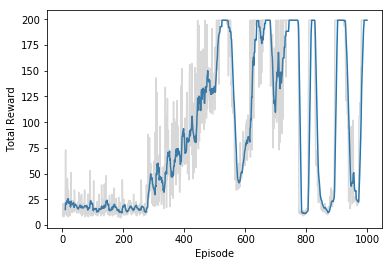

In [37]:
eps, rews = np.array(rewards_list).T
smoothed_rews = running_mean(rews, 10)
plt.plot(eps[-len(smoothed_rews):], smoothed_rews)
plt.plot(eps, rews, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total Reward')

## Testing

Let's checkout how our trained agent plays the game.

In [39]:
test_episodes = 10
test_max_steps = 400
env.reset()
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    for ep in range(1, test_episodes):
        t = 0
        while t < test_max_steps:
            #env.render() 
            
            # Get action from Q-network
            feed = {mainQN.inputs_: state.reshape((1, *state.shape))}
            Qs = sess.run(mainQN.output, feed_dict=feed)
            action = np.argmax(Qs)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
            
            if done:
                t = test_max_steps
                env.reset()
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())

            else:
                state = next_state
                t += 1

INFO:tensorflow:Restoring parameters from checkpoints/cartpole.ckpt


In [40]:
env.close()

## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.